In [69]:

%matplotlib inline

In [4]:
import os
import pandas as pd
import numpy as np
import fancyimpute
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (explained_variance_score, mean_absolute_error, mean_squared_error)
from sklearn.metrics import r2_score
def load_data():
    # define path of csv
    raw_data_path=os.path.join(os.path.pardir,'day.csv')
    # import the dataset
    df=pd.read_csv(raw_data_path)
    df.columns=['Instant', 'Date', 'Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation', 'Temp', 'ActualTemp', 'Humidity', 'WindSpeed',
           'Casual', 'Registered', 'Count']
    # Convert the categorical columns to object 
    cat_cols=['Instant','Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation']
    for i in cat_cols:
        df[i] = df[i].astype(object)
    num_cols=[]
    for i in df.columns:
        if(df[i].dtype==np.dtype('int64') or df[i].dtype==np.dtype('float64')):
            num_cols.append(i)
            df[i] = df[i].astype(np.float64)
    # viewing the dataframe's info
    df.info()
    return df
def outlier_imputer(df_o):
    # Outlier Analysis
    while True:
        for i in num_cols:
            median=np.median(df_o[i])
            std=np.std(df_o[i])
            min=(df_o[i].quantile(0.25)-1.5*(df_o[i].quantile(0.75)-df_o[i].quantile(0.25)))    
            max=(df_o[i].quantile(0.75)+1.5*(df_o[i].quantile(0.75)-df_o[i].quantile(0.25)))
            df_o.loc[df_o[i]<min,i] = np.nan
            df_o.loc[df_o[i]>max,i] = np.nan
        missing_val = df_o.isnull().sum()
        print(missing_val)
        if(missing_val.sum()>0):
            df_o_knn=pd.DataFrame(fancyimpute.KNN(k = 3).complete(df_o[num_cols]), columns = num_cols)
            df_o.iloc[:,9:]=df_o_knn.iloc[:,1:]
        else:
            break
    return df_o
def feature_selection(df):
    #Set the width and hieght of the plot
    f, ax = plt.subplots(figsize=(7, 5))
    #Generate correlation matrix
    corr = df.iloc[:,9:].corr()
    #Plot using seaborn library
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    return df.drop(['Instant','Date','Holiday','Temp','Registered'],axis=1,inplace=False)
def split_dataset(df):
    X=df.iloc[:,:-1].values
    y=df.iloc[:,-1].values
    return train_test_split(X,y,test_size=0.2,random_state=123)
def feature_scaling(X_train,X_test):
    standardScaler=StandardScaler()
    X_train[:,6:]=standardScaler.fit_transform(X_train[:,6:])
    X_test[:,6:]=standardScaler.transform(X_test[:,6:])
    return X_train,X_test,standardScaler
def train_lm(X_train,y_train):
    lr_model=LinearRegression()
    lr_model.fit(X_train,y_train)
    return lr_model
def train_dt(X_train,y_train):
    dtr_model=DecisionTreeRegressor(random_state=123)
    dtr_model.fit(X_train,y_train)
    return dtr_model
def train_rf(X_train,y_train):
    rf_model=RandomForestRegressor(n_estimators=50,random_state=123)
    rf_model.fit(X_train,y_train)
    return rf_model
def train_knn(X_train,y_train):
    rf_model=KNeighborsRegressor(n_neighbors=5)
    rf_model.fit(X_train,y_train)
    return rf_model
def predict_vals(model,X_test,y_test):
    print(model.score(X_test,y_test))
    preds=model.predict(X_test)
    return preds
def evaluate_model(y_test,y_pred):
    print('R-Square',r2_score(y_test,y_pred))
    print('MSE',mean_squared_error(y_test,y_pred))
    print('MAE',mean_absolute_error(y_test,y_pred))
    print('Explained Variance',explained_variance_score(y_test,y_pred))
def predict(model,X):
    df=X
    df.columns=['Instant', 'Date', 'Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation', 'Temp', 'ActualTemp', 'Humidity', 'WindSpeed',
           'Casual', 'Registered']
    # Convert the categorical columns to object 
    cat_cols=['Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation']
    for i in cat_cols:
        df[i] = df[i].astype(object)
    num_cols=[]
    for i in df.columns:
        if(df[i].dtype==np.dtype('int64') or df[i].dtype==np.dtype('float64')):
            num_cols.append(i)
            df[i] = df[i].astype(np.float64)
    X.drop(['Instant','Date','Holiday','Temp','Registered'],axis=1,inplace=True)
    X=X.values
    X[:,6:]=standardScaler.transform(X[:,6:])
    return model.predict(X)
df=load_data()
df=outlier_imputer(df)
df=feature_selection(df)
X_train,X_test,y_train,y_test=split_dataset(df)
X_train_scaled,X_test_scaled,standardScaler=feature_scaling(X_train,X_test)
lr_model=train_lm(X_train,y_train)
dt_model=train_dt(X_train,y_train)
rf_model=train_rf(X_train,y_train)
knn_model=train_knn(X_train,y_train)
print('Linear Model')
y_pred=predict_vals(lr_model,X_test,y_test)
evaluate_model(y_test,y_pred)
print('Decision Tree Model')
y_pred=predict_vals(dt_model,X_test,y_test)
evaluate_model(y_test,y_pred)
print('Random Forest Model')
y_pred=predict_vals(rf_model,X_test,y_test)
evaluate_model(y_test,y_pred)
print('K Nearest Neighbors(k=5)')
y_pred=predict_vals(knn_model,X_test,y_test)
evaluate_model(y_test,y_pred)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
Instant             731 non-null object
Date                731 non-null object
Season              731 non-null object
Year                731 non-null object
Month               731 non-null object
Holiday             731 non-null object
Weekday             731 non-null object
WorkingDay          731 non-null object
WeatherSituation    731 non-null object
Temp                731 non-null float64
ActualTemp          731 non-null float64
Humidity            731 non-null float64
WindSpeed           731 non-null float64
Casual              731 non-null float64
Registered          731 non-null float64
Count               731 non-null float64
dtypes: float64(7), object(9)
memory usage: 91.5+ KB
Instant              0
Date                 0
Season               0
Year                 0
Month                0
Holiday              0
Weekday              0
WorkingDay           0
WeatherSitu

NameError: name 'plt' is not defined

In [5]:
    num_cols=[]
    for i in df.columns:
        if(df[i].dtype==np.dtype('int64') or df[i].dtype==np.dtype('float64')):
            num_cols.append(i)

In [6]:
num_cols

['Instant',
 'Temp',
 'ActualTemp',
 'Humidity',
 'WindSpeed',
 'Casual',
 'Registered',
 'Count']

In [295]:
predict(knn_model,s)



C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([3732.66666667])

In [321]:
print("The Model's Prediction for the input is",predict(rf_model,s))

The Model's Prediction for the input is [3927.8]


C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [301]:

df_n=pd.read_csv(raw_data_path)


In [310]:
df_n.iloc[:,9:-1].columns
df_n.iloc[:,-1:].columns

Index(['cnt'], dtype='object')

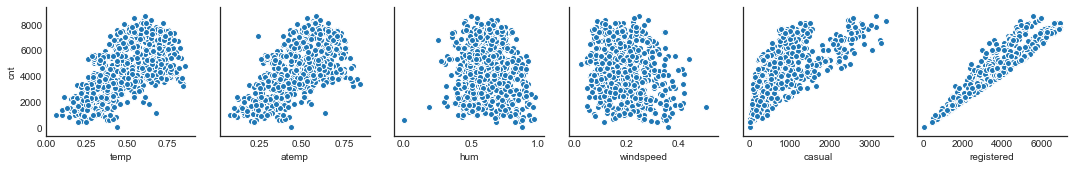

In [311]:
sns.pairplot(df_n,x_vars=df_n.iloc[:,9:-1].columns,y_vars=df_n.iloc[:,-1:].columns)

In [317]:
a=np.array([[399, '2012-02-03', 1, 1, 2, 0, 5, 1, 1, 0.313333, 0.309346,
        0.526667, 0.17849600000000002, 310, 3841]], dtype=object)

In [320]:
s=pd.DataFrame(a)

In [284]:
s.columns=['Instant', 'Date', 'Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation', 'Temp', 'ActualTemp', 'Humidity', 'WindSpeed',
           'Casual', 'Registered']

In [234]:
s.head()

,Instant,Date,Season,Year,Month,Holiday,Weekday,WorkingDay,WeatherSituation,Temp,ActualTemp,Humidity,WindSpeed,Casual,Registered,Count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


# Exploratory Data Analysis

In [184]:
# describe all the columns
df.describe(include='all')

,Instant,Date,Season,Year,Month,Holiday,Weekday,WorkingDay,WeatherSituation,Temp,ActualTemp,Humidity,WindSpeed,Casual,Registered,Count
count,731.000000,731,731.0,731.0,731.0,731.0,731.0,731.0,731.0,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
unique,NaN,731,4.0,2.0,12.0,2.0,7.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2012-01-20,3.0,1.0,12.0,0.0,6.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,188.0,366.0,62.0,710.0,105.0,500.0,463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,366.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495385,0.474354,0.629504,0.185810,811.674923,3656.172367,4504.348837
std,211.165812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.183051,0.162961,0.140063,0.070059,598.206134,1560.256377,1937.211452
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059130,0.079070,0.254167,0.022392,2.000000,20.000000,22.000000
25%,183.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.337083,0.337842,0.521041,0.134646,315.500000,2497.000000,3152.000000
50%,366.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498333,0.486733,0.627500,0.179721,713.000000,3662.000000,4548.000000
75%,548.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.655417,0.608602,0.730833,0.230098,1096.000000,4776.500000,5956.000000


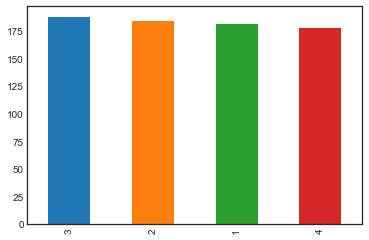

In [96]:
df.Season.value_counts().plot(kind='bar')



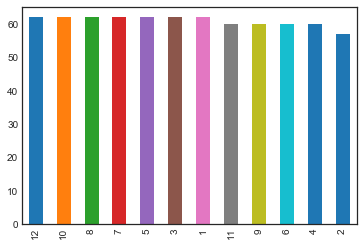

In [97]:
df.Month.value_counts().plot(kind='bar')

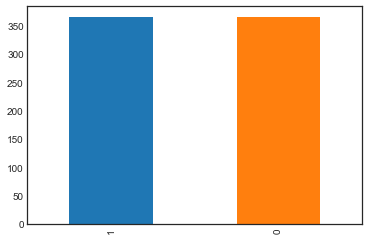

In [98]:
df.Year.value_counts().plot(kind='bar')

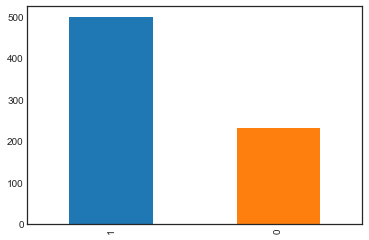

In [99]:
df.WorkingDay.value_counts().plot(kind='bar')

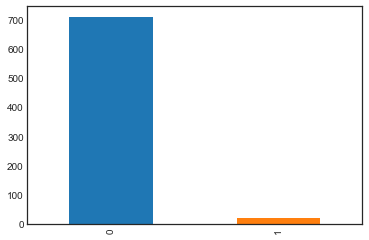

In [100]:
df.Holiday.value_counts().plot(kind='bar')

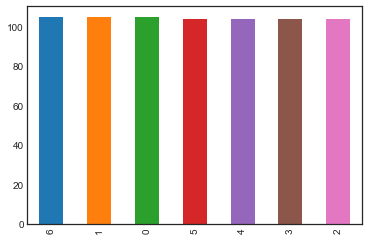

In [101]:
df.Weekday.value_counts().plot(kind='bar')

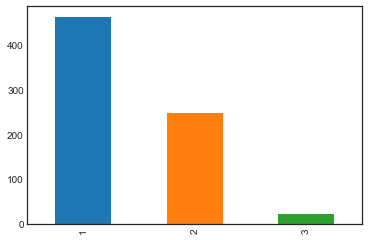

In [102]:
df.WeatherSituation.value_counts().plot(kind='bar')

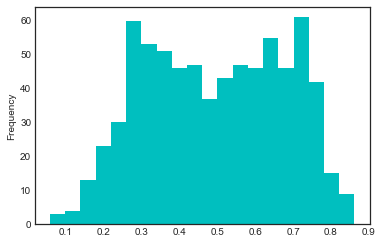

In [103]:
df.Temp.plot(kind='hist',bins=20,color='c')

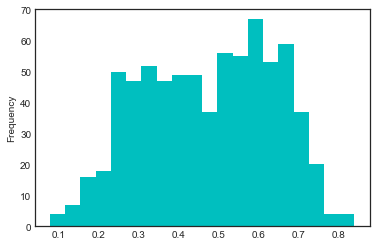

In [104]:
df.ActualTemp.plot(kind='hist',bins=20,color='c')

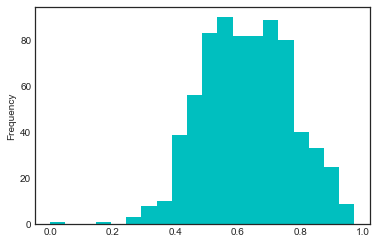

In [105]:
df.Humidity.plot(kind='hist',bins=20,color='c')

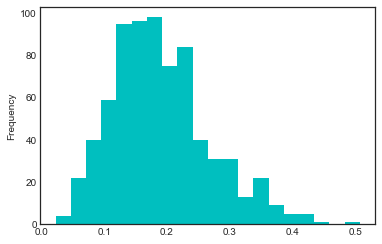

In [106]:
df.WindSpeed.plot(kind='hist',bins=20,color='c')

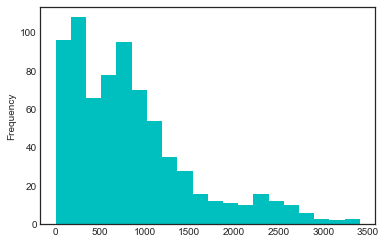

In [107]:
df.Casual.plot(kind='hist',bins=20,color='c')

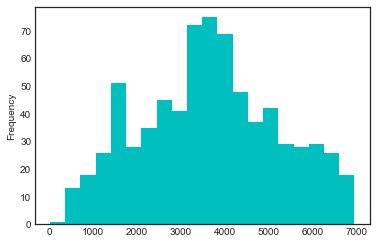

In [108]:
df.Registered.plot(kind='hist',bins=20,color='c')

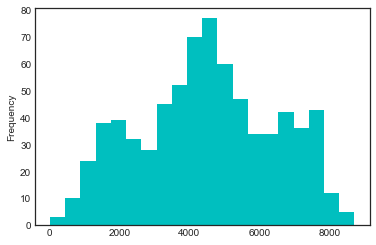

In [109]:
df.Count.plot(kind='hist',bins=20,color='c')

In [171]:
df_o=df.copy()
df.Casual.quantile(0.75)

1096.0

In [172]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
Instant             731 non-null float64
Date                731 non-null object
Season              731 non-null object
Year                731 non-null object
Month               731 non-null object
Holiday             731 non-null object
Weekday             731 non-null object
WorkingDay          731 non-null object
WeatherSituation    731 non-null object
Temp                731 non-null float64
ActualTemp          731 non-null float64
Humidity            731 non-null float64
WindSpeed           731 non-null float64
Casual              731 non-null float64
Registered          731 non-null float64
Count               731 non-null float64
dtypes: float64(8), object(8)
memory usage: 91.5+ KB


In [173]:
import fancyimpute
# Outlier Analysis
while True:
    for i in num_cols:
        median=np.median(df_o[i])
        std=np.std(df_o[i])
        min=(df_o[i].quantile(0.25)-1.5*(df_o[i].quantile(0.75)-df_o[i].quantile(0.25)))    
        max=(df_o[i].quantile(0.75)+1.5*(df_o[i].quantile(0.75)-df_o[i].quantile(0.25)))
        df_o.loc[df_o[i]<min,i] = np.nan
        df_o.loc[df_o[i]>max,i] = np.nan
    missing_val = df_o.isnull().sum()
    print(missing_val)
    if(missing_val.sum()>0):
        df_o_knn=pd.DataFrame(fancyimpute.KNN(k = 3).complete(df_o[num_cols]), columns = num_cols)
        df_o.iloc[:,9:]=df_o_knn.iloc[:,1:]
    else:
        break


Instant              0
Date                 0
Season               0
Year                 0
Month                0
Holiday              0
Weekday              0
WorkingDay           0
WeatherSituation     0
Temp                 0
ActualTemp           0
Humidity             2
WindSpeed           13
Casual              44
Registered           0
Count                0
dtype: int64
Imputing row 1/731 with 0 missing, elapsed time: 0.062
Imputing row 101/731 with 0 missing, elapsed time: 0.063
Imputing row 201/731 with 0 missing, elapsed time: 0.064
Imputing row 301/731 with 0 missing, elapsed time: 0.064
Imputing row 401/731 with 0 missing, elapsed time: 0.064
Imputing row 501/731 with 0 missing, elapsed time: 0.065
Imputing row 601/731 with 0 missing, elapsed time: 0.066
Imputing row 701/731 with 0 missing, elapsed time: 0.066
Instant             0
Date                0
Season              0
Year                0
Month               0
Holiday             0
Weekday             0
WorkingDay 

In [155]:
df_o_knn.iloc[:,1:]

,Temp,ActualTemp,Humidity,WindSpeed,Casual,Registered,Count
0,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
1,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
2,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
3,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
4,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0
5,0.204348,0.233209,0.518261,0.089565,88.0,1518.0,1606.0
6,0.196522,0.208839,0.498696,0.168726,148.0,1362.0,1510.0
7,0.165000,0.162254,0.535833,0.266804,68.0,891.0,959.0
8,0.138333,0.116175,0.434167,0.361950,54.0,768.0,822.0
9,0.150833,0.150888,0.482917,0.223267,41.0,1280.0,1321.0


In [164]:
df_o.iloc[:,9:]=df_o_knn.iloc[:,1:]

In [157]:
missing_val.sum()

59

In [286]:
from sklearn.neighbors import KNeighborsRegressor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
Instant             731 non-null object
Date                731 non-null object
Season              731 non-null object
Year                731 non-null object
Month               731 non-null object
Holiday             731 non-null object
Weekday             731 non-null object
WorkingDay          731 non-null object
WeatherSituation    731 non-null object
Temp                731 non-null float64
ActualTemp          731 non-null float64
Humidity            731 non-null float64
WindSpeed           731 non-null float64
Casual              731 non-null float64
Registered          731 non-null float64
Count               731 non-null float64
dtypes: float64(7), object(9)
memory usage: 91.5+ KB
Instant              0
Date                 0
Season               0
Year                 0
Month                0
Holiday              0
Weekday              0
WorkingDay           0
WeatherSitu

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Linear Model
0.8613684407429528
R-Square 0.8613684407429528
MSE 473067.04385924723
MAE 527.2589322106459
Explained Variance 0.8617690553494943
Decision Tree Model
0.7867354310762626
R-Square 0.7867354310762626
MSE 727745.1088435374
MAE 563.4761904761905
Explained Variance 0.7868670204580023
Random Forest Model
0.8985143064559096
R-Square 0.8985143064559096
MSE 346310.30117673473
MAE 422.60036734693875
Explained Variance 0.8987711433266465
K Nearest Neighbors(k=5)
0.7585757909474694
R-Square 0.7585757909474694
MSE 823837.2092517007
MAE 691.8585034013605
Explained Variance 0.7599280287568988


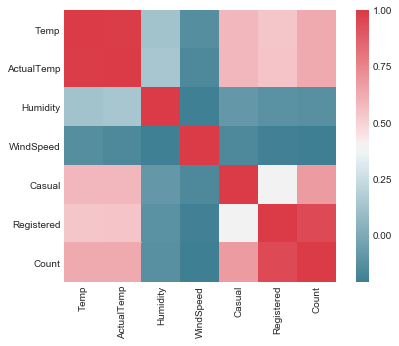

In [342]:
import os
import pandas as pd
import numpy as np
import fancyimpute
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (explained_variance_score, mean_absolute_error, mean_squared_error)
from sklearn.metrics import r2_score
def load_data():
    # define path of csv
    raw_data_path=os.path.join(os.path.pardir,'day.csv')
    # import the dataset
    df=pd.read_csv(raw_data_path)
    df.columns=['Instant', 'Date', 'Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation', 'Temp', 'ActualTemp', 'Humidity', 'WindSpeed',
           'Casual', 'Registered', 'Count']
    # Convert the categorical columns to object 
    cat_cols=['Instant','Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation']
    for i in cat_cols:
        df[i] = df[i].astype(object)
    num_cols=[]
    for i in df.columns:
        if(df[i].dtype==np.dtype('int64') or df[i].dtype==np.dtype('float64')):
            num_cols.append(i)
            df[i] = df[i].astype(np.float64)
    # viewing the dataframe's info
    df.info()
    return df
def outlier_imputer(df_o):
    # Outlier Analysis
    while True:
        for i in num_cols:
            median=np.median(df_o[i])
            std=np.std(df_o[i])
            min=(df_o[i].quantile(0.25)-1.5*(df_o[i].quantile(0.75)-df_o[i].quantile(0.25)))    
            max=(df_o[i].quantile(0.75)+1.5*(df_o[i].quantile(0.75)-df_o[i].quantile(0.25)))
            df_o.loc[df_o[i]<min,i] = np.nan
            df_o.loc[df_o[i]>max,i] = np.nan
        missing_val = df_o.isnull().sum()
        print(missing_val)
        if(missing_val.sum()>0):
            df_o_knn=pd.DataFrame(fancyimpute.KNN(k = 3).complete(df_o[num_cols]), columns = num_cols)
            df_o.iloc[:,9:]=df_o_knn.iloc[:,1:]
        else:
            break
    return df_o
def feature_selection(df):
    #Set the width and hieght of the plot
    f, ax = plt.subplots(figsize=(7, 5))
    #Generate correlation matrix
    corr = df.iloc[:,9:].corr()
    #Plot using seaborn library
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    return df.drop(['Instant','Date','Holiday','Temp','Registered'],axis=1,inplace=False)
def split_dataset(df):
    X=df.iloc[:,:-1].values
    y=df.iloc[:,-1].values
    return train_test_split(X,y,test_size=0.2,random_state=123)
def feature_scaling(X_train,X_test):
    standardScaler=StandardScaler()
    X_train[:,6:]=standardScaler.fit_transform(X_train[:,6:])
    X_test[:,6:]=standardScaler.transform(X_test[:,6:])
    return X_train,X_test,standardScaler
def train_lm(X_train,y_train):
    lr_model=LinearRegression()
    lr_model.fit(X_train,y_train)
    return lr_model
def train_dt(X_train,y_train):
    dtr_model=DecisionTreeRegressor(random_state=123)
    dtr_model.fit(X_train,y_train)
    return dtr_model
def train_rf(X_train,y_train):
    rf_model=RandomForestRegressor(n_estimators=500,criterion= 'friedman_mse',random_state=123)
    rf_model.fit(X_train,y_train)
    return rf_model
def train_knn(X_train,y_train):
    rf_model=KNeighborsRegressor(n_neighbors=5)
    rf_model.fit(X_train,y_train)
    return rf_model
def predict_vals(model,X_test,y_test):
    print(model.score(X_test,y_test))
    preds=model.predict(X_test)
    return preds
def evaluate_model(y_test,y_pred):
    print('R-Square',r2_score(y_test,y_pred))
    print('MSE',mean_squared_error(y_test,y_pred))
    print('MAE',mean_absolute_error(y_test,y_pred))
    print('Explained Variance',explained_variance_score(y_test,y_pred))
def predict(model,X):
    df=X
    df.columns=['Instant', 'Date', 'Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation', 'Temp', 'ActualTemp', 'Humidity', 'WindSpeed',
           'Casual', 'Registered']
    # Convert the categorical columns to object 
    cat_cols=['Season', 'Year', 'Month', 'Holiday', 'Weekday',
           'WorkingDay', 'WeatherSituation']
    for i in cat_cols:
        df[i] = df[i].astype(object)
    num_cols=[]
    for i in df.columns:
        if(df[i].dtype==np.dtype('int64') or df[i].dtype==np.dtype('float64')):
            num_cols.append(i)
            df[i] = df[i].astype(np.float64)
    X.drop(['Instant','Date','Holiday','Temp','Registered'],axis=1,inplace=True)
    X=X.values
    X[:,6:]=standardScaler.transform(X[:,6:])
    return model.predict(X)
df=load_data()
df=outlier_imputer(df)
df=feature_selection(df)
X_train,X_test,y_train,y_test=split_dataset(df)
X_train_scaled,X_test_scaled,standardScaler=feature_scaling(X_train,X_test)
lr_model=train_lm(X_train,y_train)
dt_model=train_dt(X_train,y_train)
rf_model=train_rf(X_train,y_train)
knn_model=train_knn(X_train,y_train)
print('Linear Model')
y_pred=predict_vals(lr_model,X_test_scaled,y_test)
evaluate_model(y_test,y_pred)
print('Decision Tree Model')
y_pred=predict_vals(dt_model,X_test_scaled,y_test)
evaluate_model(y_test,y_pred)
print('Random Forest Model')
y_pred=predict_vals(rf_model,X_test_scaled,y_test)
evaluate_model(y_test,y_pred)
print('K Nearest Neighbors(k=5)')
y_pred=predict_vals(knn_model,X_test_scaled,y_test)
evaluate_model(y_test,y_pred)

In [329]:
accuracies_lr=cross_val_score(lr_model,X_train_scaled,y_train,cv=10)
print('Linear Model')
print('Mean accuracy',np.mean(accuracies_lr))
print('Standard Deviation of Model Accuracies',np.std(accuracies_lr))
print('Decision Tree Model')
accuracies_lr=cross_val_score(dt_model,X_train_scaled,y_train,cv=10)
print('Mean accuracy',np.mean(accuracies_lr))
print('Standard Deviation of Model Accuracies',np.std(accuracies_lr))
print('Random Forest Model')

accuracies_lr=cross_val_score(rf_model,X_train_scaled,y_train,cv=10)
print('Mean accuracy',np.mean(accuracies_lr))
print('Standard Deviation of Model Accuracies',np.std(accuracies_lr))
print('Knn Model')

accuracies_lr=cross_val_score(knn_model,X_train_scaled,y_train,cv=10)
print('Mean accuracy',np.mean(accuracies_lr))
print('Standard Deviation of Model Accuracies',np.std(accuracies_lr))

Linear Model
Mean accuracy 0.8780544800280978
Standard Deviation of Model Accuracies 0.04191051108098907
Decision Tree Model
Mean accuracy 0.8304936120240107
Standard Deviation of Model Accuracies 0.057940876210777634
Random Forest Model
Mean accuracy 0.9090659490048114
Standard Deviation of Model Accuracies 0.03373329331604746
Knn Model
Mean accuracy 0.7538481034697936
Standard Deviation of Model Accuracies 0.07700789231686189


In [343]:
knn_params=[{'n_neighbors':[3,5,7,9,11],'weights':['uniform','distance'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],'metric':['euclidean','manhattan','minkowski']}]


In [330]:
from sklearn.model_selection import GridSearchCV
dt_params=[{'criterion':['mse','mae','friedman_mse'],'splitter':['best','random']}]
rf_params=[{'criterion':['mse','mae','friedman_mse'],'n_estimators':[10,50,100,500]}]


In [344]:
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(knn_model,knn_params,cv=10)

In [345]:
g=grid_search.fit(X_train_scaled,y_train)

In [346]:
g.best_params_

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'distance'}

In [347]:
g.best_score_

0.8092599865645616

In [ ]:
DistanceMetric